<a href="https://colab.research.google.com/github/richa-kaplesh/new-repositery/blob/main/PRODIGY_ML_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240626%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240626T100541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D15add611e190601aedc5d70c75adabe070044cc0f4b91c2fe93a0f8f0bad14b97ed35557a6802775b229d85fe1fc13a8c171d262b844c1a2547a959114688d9f3902d7d469cf6935b50a3685f8c41f1307bdbbefbab6e7dab563a76d9e584e1a0564dc63115749f661ef0892c1b80375593d39825ec75d4cc6ea68ea49005eba1079fe39066a4a92c62bb48fc159e2c56cdb109a03ff4484402c25f79f6668c2a63bcbcd5a723b189f26a86bdeb12470da8b36b7cd664cce0f13131f2847e2898e62c8c8cc39a1a323c8a11d8749e6b2e42a8b221b14dc881e86c9544fbaa573268d7124d279fe74df0e3ec6fa953fb926f3180ac4dcbbb125825647ea488acc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


## Importing the Usefull Modules

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = datagen.flow_from_directory(
        "../input/cat-and-dog/training_set/training_set/",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )


Found 8005 images belonging to 2 classes.


### Preprocessing the test Data using ImageDataGenerator

In [ ]:
datagen1 = ImageDataGenerator(rescale=1./255)

test_set = datagen1.flow_from_directory(
        "../input/cat-and-dog/test_set/test_set",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 2023 images belonging to 2 classes.


# Creating the Model

### Importing useful models for CNN Layers

In [ ]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [ ]:
from tensorflow.keras.regularizers import l2

### When to use a Sequential model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

A Sequential model is **not appropriate** when:
- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)


In [ ]:
cnn = tf.keras.models.Sequential()

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

### Step 2 - Pooling
Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [ ]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [ ]:
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

### Printing out the summary of the Layers

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               2

## Training the CNN

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [ ]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
251/251 [==============================] - 50s 191ms/step - loss: 0.9333 - accuracy: 0.5492 - val_loss: 0.7826 - val_accuracy: 0.5912
Epoch 2/15
251/251 [==============================] - 39s 156ms/step - loss: 0.7457 - accuracy: 0.6496 - val_loss: 0.7240 - val_accuracy: 0.6125
Epoch 3/15
251/251 [==============================] - 32s 129ms/step - loss: 0.6797 - accuracy: 0.6800 - val_loss: 0.6411 - val_accuracy: 0.7128
Epoch 4/15
251/251 [==============================] - 31s 125ms/step - loss: 0.6268 - accuracy: 0.7096 - val_loss: 0.6232 - val_accuracy: 0.7222
Epoch 5/15
251/251 [==============================] - 33s 130ms/step - loss: 0.6092 - accuracy: 0.7177 - val_loss: 0.6086 - val_accuracy: 0.7296
Epoch 6/15
251/251 [==============================] - 31s 124ms/step - loss: 0.5764 - accuracy: 0.7343 - val_loss: 0.6991 - val_accuracy: 0.7395
Epoch 7/15
251/251 [==============================] - 32s 127ms/step - loss: 0.5725 - accuracy: 0.7380 - val_loss: 0.5571 - val_ac

## Ploting the Train loss,val loss and train acc, val acc

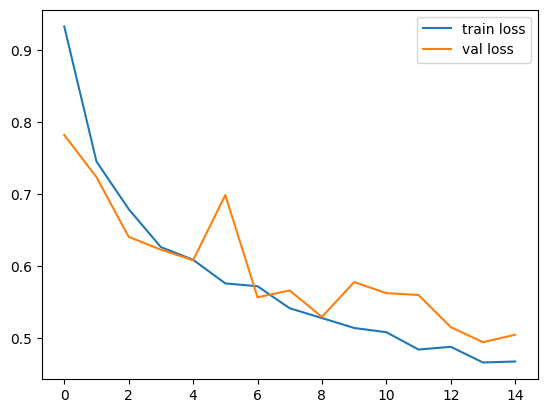

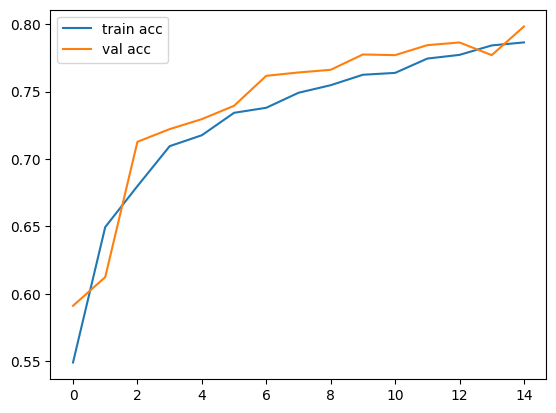

In [ ]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Saving the trained model

In [ ]:
from tensorflow.keras.models import load_model

cnn.save('./model_rcat_dog.h5')

### Taking the sample image converting the image to an array and predicting the result

In [ ]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('../input/cat-and-dog/training_set/training_set/dogs/dog.1023.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

1/1 [==============================] - 0s 148ms/step


In [ ]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is dog
